#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$y \sim Exponential(\lambda),$$
where:
$$\lambda = exp(f) \in (0,+\infty)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In other words, given inputs $X$ and observations $Y$ drawn from exponential distribution with $\lambda = \lambda(X)$, we want to find $\lambda(X)$.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)+1.2 

# Generate Synthetic Data

In the next cell, we generate synthetic data from the generative process described above, using $sin(2\pi x) + 1$ as the true scale function. On the domain $[0, 1.0]$, we expect smaller $x$ values to give rise to y values from exponential distributions with larger scale parameters. We plot samples from the true exponential distribution at each training x value we generate.

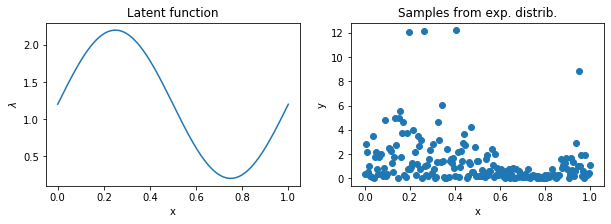

In [88]:
# here we generate some synthetic samples
NSamp = 200

X = np.linspace(0,1,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,3))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

Y = np.zeros_like(X)
for i,x in enumerate(X):
    Y[i] = np.random.exponential(scale(x), 1)
samples.scatter(X,Y)
samples.set_xlabel('x')
samples.set_ylabel('y')
samples.set_title('Samples from exp. distrib.')

fig.show()

In [89]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float()#.cuda()
train_y = torch.tensor(Y).float()#.cuda()

# Define Pyro variational GP model

In GPyTorch, a pyro variational GP model is identical to a standard variational GP model, except (1) it extends `PyroVariationalGP` instead of `AbstractVariationalGP`, and (2) it defines a `name_prefix`, which is used in `pyro.sample` and `pyro.module` calls.

In general, a `PyroVariationalGP` model also defines a `model` and `guide`. However, for this latent function example, we are able to use the default `model` and `guide` defined in the base class.

In [331]:
class PVGPRegressionModel(gpytorch.models.AbstractVariationalGP):
    def __init__(self, train_x, likelihood):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_x.numel()
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )
        
        # Standard initializtation
        super(PVGPRegressionModel, self).__init__(variational_strategy)
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        
        #we specify prior here
        prior_rbf_length = 0.2 
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        #self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# Define the Likelihood

The primary "new" thing we need to define for this sort of latent function inference is a new likelihood, `p(y|f)`. In this case, the mapping is `p(y|f) = Exponential(exp(f))`. See the docs for `gpytorch.likelihoods.Likelihood` for more information on what each method does.

In [462]:
from torch import Tensor
from typing import Any
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.distributions import MultivariateNormal, base_distributions
from gpytorch.utils.deprecation import _deprecate_kwarg_with_transform

class InfTheta_ExpDist_Likelihood(Likelihood):
    def __init__(self, noise_prior=None, noise_constraint=None, batch_shape=torch.Size(), **kwargs: Any):
        batch_shape = _deprecate_kwarg_with_transform(
            kwargs, "batch_size", "batch_shape", batch_shape, lambda n: torch.Size([n])
        )
        super(Likelihood, self).__init__()
        self._max_plate_nesting = 1

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        #mean, variance = input.mean, input.variance
        thetas = self.gplink_function(input.rsample(torch.Size([100])))
        res = - thetas * target + thetas.log()
        #print(res.shape,res.mean(0).shape)
        return -res.mean()
    
    @staticmethod
    def gplink_function(f: Tensor) -> Tensor:
        """
        GP link function transforms the GP latent variable `f` into :math:`\theta`,
        which parameterizes the distribution in :attr:`forward` method as well as the
        log likelihood of this distribution defined in :attr:`expected_log_prob`.
        """
        return f.exp()
    
    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any) -> base_distributions.Exponential:        
        scale = self.gplink_function(function_samples)
        return base_distributions.Exponential(scale.pow(-1)) # rate = 1/scale

In [522]:
help(base_distributions.Exponential)

Help on class Exponential in module pyro.distributions.torch:

class Exponential(torch.distributions.exponential.Exponential, pyro.distributions.torch_distribution.TorchDistributionMixin)
 |  Wraps :class:`torch.distributions.exponential.Exponential` with
 |  :class:`~pyro.distributions.torch_distribution.TorchDistributionMixin`.
 |  
 |  Method resolution order:
 |      Exponential
 |      torch.distributions.exponential.Exponential
 |      torch.distributions.exp_family.ExponentialFamily
 |      torch.distributions.distribution.Distribution
 |      pyro.distributions.torch_distribution.TorchDistributionMixin
 |      pyro.distributions.distribution.Distribution
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from torch.distributions.exponential.Exponential:
 |  
 |  __init__(self, rate, validate_args=None)
 |      Ini

In [463]:
for n,p in model.named_parameters():
    print(n)
for n,p in model.likelihood.named_parameters():
    print(n)

variational_strategy.variational_distribution.variational_mean
variational_strategy.variational_distribution.chol_variational_covar
mean_module.constant
covar_module.raw_outputscale
covar_module.base_kernel.raw_lengthscale


In [517]:
# define the model (optionally on GPU)
model = PVGPRegressionModel(train_x, InfTheta_ExpDist_Likelihood())#.cuda()

# Train the Model

In the next cell we use Pyro SVI to train the model. See the Pyro docs for general examples of this, as well as our simpler Pyro integration notebooks.

In [518]:
# train the model

base_lr = .05/NSamp
iter_print = 50

print('Basic lr for most of parameters: {}'.format(base_lr))

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.covar_module.raw_outputscale},
    {'params': model.variational_strategy.variational_distribution.variational_mean, 'lr': 5.0},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .005} #, 'lr': 0.001
], lr=base_lr)

losses, rbf, means = [], [], []

def train(num_iter=200):
    # Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
    mll = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
    model.train()

    for i in range(num_iter):
        optimizer.zero_grad()

        output = model(train_x)
        #loss = -mll(output, train_y)
        log_lik, kl_div, log_prior = torch.zeros(1),torch.zeros(1),torch.zeros(1)
        loss = -mll(output, train_y)#/NSamp
#         log_lik = log_lik/NSamp
#         loss = -(-log_lik - kl_div + log_prior)

        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        if not (i + 1) % iter_print:
            print('Epoch %d/%d - Loss: %.3f [%.3f, %.3f, %.3f] \
                  lengthscale: %.3f' % \
                  (i + 1, num_iter, loss.item(), 
                   log_lik.item(), kl_div.item(), log_prior.item(), 
                   model.covar_module.base_kernel.lengthscale.item()))
            means.append(model.variational_strategy.variational_distribution.\
                         variational_mean.detach().cpu().numpy().copy())
            

        loss.backward()
        optimizer.step()

%time train()

Basic lr for most of parameters: 0.00025
Epoch 50/200 - Loss: 31.392 [0.000, 0.000, 0.000]                   lengthscale: 0.184
Epoch 100/200 - Loss: 0.098 [0.000, 0.000, 0.000]                   lengthscale: 0.183
Epoch 150/200 - Loss: 0.021 [0.000, 0.000, 0.000]                   lengthscale: 0.183
Epoch 200/200 - Loss: -0.025 [0.000, 0.000, 0.000]                   lengthscale: 0.183
CPU times: user 4min 14s, sys: 224 ms, total: 4min 14s
Wall time: 11.6 s


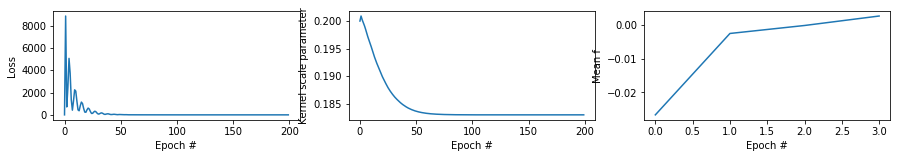

In [519]:
# prot loss function and kernel length
model.eval()
fig, (lossp, kern, mean) = plt.subplots(1,3,figsize=(15,2))
lossp.plot(losses)
lossp.set_xlabel("Epoch #")
lossp.set_ylabel("Loss")
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

# Make Predictions and Plot

In the next cell, we get predictions. In particular, we plot the expected scale function learned by the GP, as well as samples drawn from the predictive distribution `p(y|D)`.

In [520]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float()#.cuda()

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function


# Get E[exp(f)] via f_i ~ GP, 1/n \sum_{i=1}^{n} exp(f_i). Similarly get sample variances.
#samples = output.rsample(torch.Size([2048]))
F_mean = gplink(output.mean)#gplink(samples).mean(0)
lower, upper = output.confidence_region()
lower = gplink(lower)
upper = gplink(upper)

with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample()

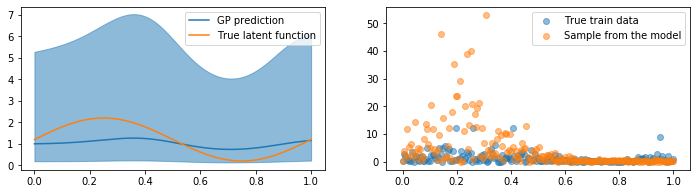

In [521]:
# visualize the result
fig, (func, samp) = plt.subplots(1,2,figsize=(12, 3))

line, = func.plot(testX, F_mean.detach().cpu().numpy(), label = 'GP prediction')
func.fill_between(testX, lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
#func.set_xlabel('x')
#func.set_ylabel('gp_link(f)')
#func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(X, Y, alpha = 0.5, label = 'True train data')
samp.scatter(X, Y_sim.cpu().detach().numpy(), alpha = 0.5, label = 'Sample from the model')
#samp.set_xlabel('x')
#samp.set_ylabel('y')
#samp.set_title('Samples from exp. distrib. with scale=gplink(f(x))')
samp.legend()

fig.show()

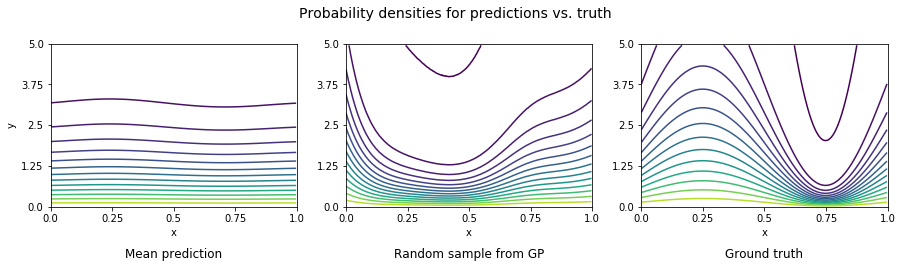

In [469]:
# visualize pdf for y(x)

from scipy import stats

Nbins = 100

latent_sample = gplink(output.sample()).cpu().numpy()

img = np.zeros((Nbins,denser*NSamp,3))
h = np.linspace(1e-4,5,Nbins)

for i, (l, m, t) in enumerate(zip(latent_sample, F_mean, scale(testX)+1e-2)):
    img[:,i,0] = stats.expon.pdf(h, scale=m.detach())
    img[:,i,1] = stats.expon.pdf(h, scale=l)
    img[:,i,2] = stats.expon.pdf(h, scale=t)

img = img / np.max(img,axis=0) # normalize pdf, so that max(pdf) = 1

num_levels = 15

levels = np.exp(np.linspace(1e-4,1,num_levels))
levels -= 1
levels /= np.max(levels)

fig, ax = plt.subplots(1,3, figsize = (15,3))
for c, n in enumerate(['Mean prediction', 'Random sample from GP', 'Ground truth']):
    ax[c].contour(img[:,:,c], levels = levels)
    ax[c].set_yticks(np.linspace(0,Nbins,5))
    ax[c].set_yticklabels(np.linspace(0,5,5))
    ax[c].set_xticks(np.linspace(0,denser*NSamp,5))
    ax[c].set_xticklabels(np.linspace(0,1,5))
    ax[c].set_xlabel('x')
    ax[c].set_title(n, y=-0.35)
ax[0].set_ylabel('y')
fig.suptitle('Probability densities for predictions vs. truth', y=1.05, fontsize=14);